# 等离子体波动分析

In [94]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy.mathematics
import scipy.signal
import scipy.optimize as op
%config InlineBackend.figure_format = 'svg'

## 参数设定

In [278]:
k = 0.6
L = 2*np.pi/k
num = 1.e5  # 粒子数
tem = 1  # 温度

vmax = 5. # 速度最大值
max_steps = 1000  # 最大时间步数
q = np.sqrt(L/num)
v_th = np.sqrt(2*tem)
timestep = 0.1
path = './data/'
uae = 0.1
# 等离子体参量
dens = num /L
l_D = np.sqrt( tem / dens / q**2 ) # $\lambda_D^2$
w_pe = np.sqrt( dens * q**2 )

In [279]:
print(l_D)

0.9999999999999999


## 色散关系
$$1 + \frac{1}{ k^2 \lambda_D^2 } [1+\zeta Z(\zeta)]=0$$
- 其中$\zeta=\frac{\omega}{kv_{th}}$，$v_{th}=\sqrt{\frac{2kT}{m_e}}$

In [280]:
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])

k =  0.6
w_r =  1.5457067550863073
w_i =  -0.26411033818821705


In [281]:
print("rt = ", abs(s.x[1]/np.sqrt(uae)))

rt =  0.8351902222721144


In [282]:
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
kvec = np.arange(.1,1.2,0.1)
#kvec = np.arange(k-0.3,k+0.4,0.1)
table = PrettyTable(['k','k*l_D','w_r','w_i','v_p/v_th'])
for ki in kvec:
    s=op.root(lambda w:eq4PDRM(w,ki),[1,0.1])
    vp2vth=s.x[0]/ki/v_th
    ki4p=round(ki,6)
    kl4p=round(ki*l_D,6)
    wr4p=round(s.x[0],6)
    wi4p=round(s.x[1],6)
    vp4p=round(vp2vth,6)
    table.add_row([ki4p,kl4p,wr4p,wi4p,vp4p])
print(table)

+-----+-------+----------+-----------+----------+
|  k  | k*l_D |   w_r    |    w_i    | v_p/v_th |
+-----+-------+----------+-----------+----------+
| 0.1 |  0.1  | 1.015198 |    -0.0   | 7.178531 |
| 0.2 |  0.2  | 1.063984 |  -5.5e-05 | 3.761753 |
| 0.3 |  0.3  | 1.159846 |  -0.01262 | 2.733784 |
| 0.4 |  0.4  | 1.285057 | -0.066128 | 2.271681 |
| 0.5 |  0.5  | 1.415662 | -0.153359 | 2.002048 |
| 0.6 |  0.6  | 1.545707 |  -0.26411 | 1.821633 |
| 0.7 |  0.7  | 1.673866 | -0.392401 | 1.69086  |
| 0.8 |  0.8  | 1.799899 | -0.534552 | 1.590901 |
| 0.9 |  0.9  | 1.923865 | -0.688109 | 1.511531 |
| 1.0 |  1.0  | 2.045905 |  -0.85133 | 1.446673 |
| 1.1 |  1.1  | 2.166175 | -1.022919 | 1.39247  |
+-----+-------+----------+-----------+----------+


In [283]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))
dataep = np.loadtxt(os.path.join(path,"pot_energy"))
dataek = np.loadtxt(os.path.join(path,"kin_energy"))

t = np.linspace(0, max_steps, max_steps)

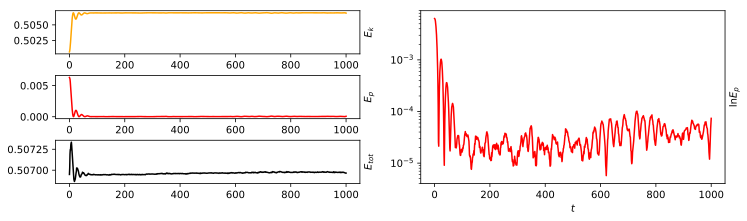

In [284]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [285]:
def line(p, x):
    k, b = p
    return k*x+b


def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r


def period(x):
    return (x[1]-x[0])/1.


def errPercent(a, b):
    r = abs(a-b)/b
    return r

In [286]:
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
s_wr,s_wi=s.x

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [289]:
indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[0:3:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * timestep
w_r_sim = 2*np.pi/per_sim/2
w_i_sim = para[0]/timestep/2
wc_table=PrettyTable(['w_r_theo','w_r_sim','err w_r(%)','w_i_theo','w_i_sim','err w_i(%)'])
wc_table.add_row([s_wr,w_r_sim,errPercent(w_r_sim,s_wr)*100,s_wi,w_i_sim,errPercent(w_i_sim,s_wi)*100])
print(wc_table)

+--------------------+--------------------+-------------------+----------------------+----------------------+--------------------+
|      w_r_theo      |      w_r_sim       |     err w_r(%)    |       w_i_theo       |       w_i_sim        |     err w_i(%)     |
+--------------------+--------------------+-------------------+----------------------+----------------------+--------------------+
| 1.5457067550863073 | 1.6534698176788383 | 6.971766296415898 | -0.26411033818821705 | -0.23935846171209169 | -9.371793866882278 |
+--------------------+--------------------+-------------------+----------------------+----------------------+--------------------+


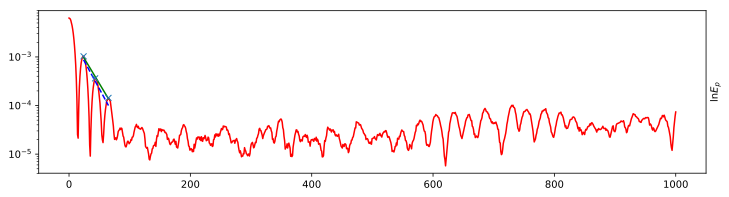

In [290]:
fig = plt.figure(figsize=(12, 3))
ax = plt.gca()
ax.plot(t, dataep, color='r')
ax.plot(xep,np.exp(line(para,xep)), '-',color='green')
ax.plot(xep,np.exp(s_wi*xep*timestep*2+para[1]), '--',color='blue')

ax.plot(xep,dataep[xep],'x')
ax.set_ylabel(r'$\ln E_p$')
ax.set_yscale('log')
ax.yaxis.set_label_position("right")
plt.show()